# Imports

In [115]:
# standard imports
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten,
from tensorflow.keras.layers import Dropout, LSTM, SimpleRNN
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
import csv
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding


# Importing and Processing the Data

In [116]:
# connecting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
#Load the data
training = pd.read_csv('/content/drive/MyDrive/CS485_Shuffled_Shakespeare.csv')
print(training)

       Label                                              Text
0          1                      And welcome merry Shrovetide
1          1         would he knew that  had saved his brother
2          1                Or any he the proudest of thy sort
3          0  Hadst thou the same free will and power to stand
4          0                  For he confounds hell in Elysium
...      ...                                               ...
44574      1   Which our profane hours here have stricken down
44575      1                   Presuming on an agues privilege
44576      0            Eden and all the coast in prospect lay
44577      0            Rose like an exhalation with the sound
44578      0         Safest and seemliest by her husband stays

[44579 rows x 2 columns]


In [119]:
# Setting the data and labels
x_train = training.pop("Text")
y_train = training.pop("Label")
print(x_train)
print(y_train)

0                            And welcome merry Shrovetide
1               would he knew that  had saved his brother
2                      Or any he the proudest of thy sort
3        Hadst thou the same free will and power to stand
4                        For he confounds hell in Elysium
                               ...                       
44574     Which our profane hours here have stricken down
44575                     Presuming on an agues privilege
44576              Eden and all the coast in prospect lay
44577              Rose like an exhalation with the sound
44578           Safest and seemliest by her husband stays
Name: Text, Length: 44579, dtype: object
0        1
1        1
2        1
3        0
4        0
        ..
44574    1
44575    1
44576    0
44577    0
44578    0
Name: Label, Length: 44579, dtype: int64


In [120]:
#Preprocessing and tokenizing
#https://medium.com/swlh/sentiment-analysis-using-word-embeddings-with-tensorflow-ab8eab7641a4
vocab_size=10000
embedding_dim=4
max_length=50
trunc_type="post"
oov_token="<OOV>"


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=max_length, truncating=trunc_type)


# The SimpleRNN Model


In [121]:

modelrnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SimpleRNN(16, return_sequences=True, recurrent_dropout = 0.2),
    Dropout(0.3),
    SimpleRNN(32, return_sequences=True, recurrent_dropout = 0.2),
    Dropout(0.3),
    SimpleRNN(16, recurrent_dropout = 0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
modelrnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelrnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 4)             40000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 50, 16)            336       
                                                                 
 dropout_8 (Dropout)         (None, 50, 16)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 32)            1568      
                                                                 
 dropout_9 (Dropout)         (None, 50, 32)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_8 (Dense)             (None, 32)               

In [122]:
num_epochs=50
history=modelrnn.fit(x_train, y_train, epochs=num_epochs, validation_split = 0.2, 
                  callbacks = [EarlyStopping(min_delta = .01, patience = 10, monitor = 'val_accuracy', verbose = 1, restore_best_weights = True)])

Epoch 1/50
1115/1115 [==============================] - 48s 40ms/step - loss: 0.6412 - accuracy: 0.6625 - val_loss: 0.6341 - val_accuracy: 0.6699
Epoch 2/50
1115/1115 [==============================] - 44s 39ms/step - loss: 0.5244 - accuracy: 0.7441 - val_loss: 0.4174 - val_accuracy: 0.8189
Epoch 3/50
1115/1115 [==============================] - 42s 38ms/step - loss: 0.3360 - accuracy: 0.8627 - val_loss: 0.3859 - val_accuracy: 0.8483
Epoch 4/50
1115/1115 [==============================] - 43s 39ms/step - loss: 0.2770 - accuracy: 0.8920 - val_loss: 0.3792 - val_accuracy: 0.8513
Epoch 5/50
1115/1115 [==============================] - 44s 39ms/step - loss: 0.2472 - accuracy: 0.9061 - val_loss: 0.3956 - val_accuracy: 0.8386
Epoch 6/50
1115/1115 [==============================] - 43s 39ms/step - loss: 0.2241 - accuracy: 0.9165 - val_loss: 0.3701 - val_accuracy: 0.8533
Epoch 7/50
1115/1115 [==============================] - 42s 38ms/step - loss: 0.2023 - accuracy: 0.9239 - val_loss: 0.4472 -

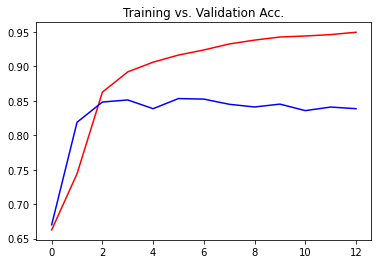

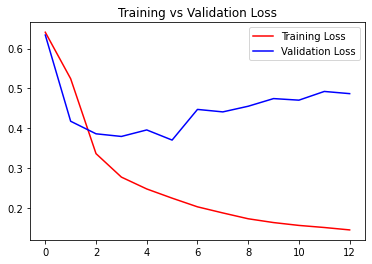

In [123]:
# plot results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Acc.')
plt.plot(epochs, val_acc, 'b', label='Validation Acc.')
plt.title('Training vs. Validation Acc.')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

# The GRU Model

In [124]:
from keras.layers.recurrent_v2 import GRU
modelgru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GRU(32, return_sequences=True, recurrent_dropout = 0.3, recurrent_regularizer=regularizers.l1_l2(0.05, 0.05)),
    Dropout(0.4),
    GRU(32, return_sequences=True, recurrent_dropout = 0.3, recurrent_regularizer=regularizers.l1_l2(0.05, 0.05)),
    Dropout(0.4),
    GRU(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
modelgru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
modelgru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 4)             40000     
                                                                 
 gru_12 (GRU)                (None, 50, 32)            3648      
                                                                 
 dropout_10 (Dropout)        (None, 50, 32)            0         
                                                                 
 gru_13 (GRU)                (None, 50, 32)            6336      
                                                                 
 dropout_11 (Dropout)        (None, 50, 32)            0         
                                                                 
 gru_14 (GRU)                (None, 32)                6336      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [125]:
num_epochs=50
historygru=modelgru.fit(x_train, y_train, epochs=num_epochs, validation_split = 0.2, 
                  callbacks = [EarlyStopping(min_delta = .01, patience = 10, monitor = 'val_accuracy', verbose = 1, restore_best_weights = True)])

Epoch 1/50
1115/1115 [==============================] - 120s 102ms/step - loss: 2.1471 - accuracy: 0.7891 - val_loss: 0.4020 - val_accuracy: 0.8401
Epoch 2/50
1115/1115 [==============================] - 113s 102ms/step - loss: 0.3291 - accuracy: 0.8801 - val_loss: 0.3748 - val_accuracy: 0.8554
Epoch 3/50
1115/1115 [==============================] - 113s 102ms/step - loss: 0.2867 - accuracy: 0.8993 - val_loss: 0.3926 - val_accuracy: 0.8526
Epoch 4/50
1115/1115 [==============================] - 113s 101ms/step - loss: 0.2645 - accuracy: 0.9101 - val_loss: 0.3816 - val_accuracy: 0.8507
Epoch 5/50
1115/1115 [==============================] - 114s 102ms/step - loss: 0.2512 - accuracy: 0.9146 - val_loss: 0.4210 - val_accuracy: 0.8489
Epoch 6/50
1115/1115 [==============================] - 113s 101ms/step - loss: 0.2385 - accuracy: 0.9189 - val_loss: 0.4338 - val_accuracy: 0.8468
Epoch 7/50
1115/1115 [==============================] - 113s 101ms/step - loss: 0.2317 - accuracy: 0.9219 - val_

Prediction Time

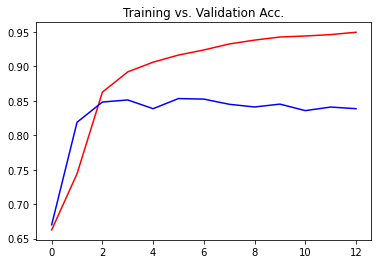

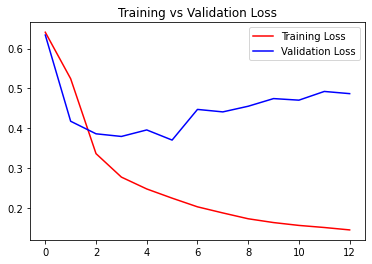

In [126]:
# plot results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Acc.')
plt.plot(epochs, val_acc, 'b', label='Validation Acc.')
plt.title('Training vs. Validation Acc.')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

# Generating Predictions


In [127]:
#Scene 1
scene1 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_1.csv')
tokenizer.fit_on_texts(scene1)
scene1 = tokenizer.texts_to_sequences(scene1)
scene1 = pad_sequences(scene1, maxlen=max_length, truncating=trunc_type)

out1rnn = modelrnn.predict(scene1)
val1rnn = np.average(out1rnn)
out1gru = modelgru.predict(scene1)
val1gru = np.average(out1gru)

In [128]:
#Scene 2
scene2 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_2.csv')
tokenizer.fit_on_texts(scene2)
scene2 = tokenizer.texts_to_sequences(scene2)
scene2 = pad_sequences(scene2, maxlen=max_length, truncating=trunc_type)

out2rnn = modelrnn.predict(scene2)
val2rnn = np.average(out2rnn)
out2gru = modelgru.predict(scene2)
val2gru = np.average(out2gru)

In [129]:
#Scene 3
scene3 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_3.csv')
tokenizer.fit_on_texts(scene3)
scene3 = tokenizer.texts_to_sequences(scene3)
scene3 = pad_sequences(scene3, maxlen=max_length, truncating=trunc_type)

out3rnn = modelrnn.predict(scene3)
val3rnn = np.average(out3rnn)
out3gru = modelgru.predict(scene3)
val3gru = np.average(out3gru)

In [130]:
#Scene 4
scene4 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_4.csv')
tokenizer.fit_on_texts(scene4)
scene4 = tokenizer.texts_to_sequences(scene4)
scene4 = pad_sequences(scene4, maxlen=max_length, truncating=trunc_type)

out4rnn = modelrnn.predict(scene4)
val4rnn = np.average(out4rnn)
out4gru = modelgru.predict(scene4)
val4gru = np.average(out4gru)

In [131]:
#Scene 5
scene5 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_5.csv')
tokenizer.fit_on_texts(scene5)
scene5 = tokenizer.texts_to_sequences(scene5)
scene5 = pad_sequences(scene5, maxlen=max_length, truncating=trunc_type)

out5rnn = modelrnn.predict(scene5)
val5rnn = np.average(out5rnn)
out5gru = modelgru.predict(scene5)
val5gru = np.average(out5gru)

In [132]:
#Scene 6
scene6 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_6.csv')
tokenizer.fit_on_texts(scene6)
scene6 = tokenizer.texts_to_sequences(scene6)
scene6 = pad_sequences(scene6, maxlen=max_length, truncating=trunc_type)

out6rnn = modelrnn.predict(scene6)
val6rnn = np.average(out6rnn)
out6gru = modelgru.predict(scene6)
val6gru = np.average(out6gru)

In [133]:
#Scene 7
scene7 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_7.csv')
tokenizer.fit_on_texts(scene7)
scene7 = tokenizer.texts_to_sequences(scene7)
scene7 = pad_sequences(scene7, maxlen=max_length, truncating=trunc_type)

out7rnn = modelrnn.predict(scene7)
val7rnn = np.average(out7rnn)
out7gru = modelgru.predict(scene7)
val7gru = np.average(out7gru)

In [134]:
#Scene 8
scene8 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_8.csv')
tokenizer.fit_on_texts(scene8)
scene8 = tokenizer.texts_to_sequences(scene8)
scene8 = pad_sequences(scene8, maxlen=max_length, truncating=trunc_type)

out8rnn = modelrnn.predict(scene8)
val8rnn = np.average(out8rnn)
out8gru = modelgru.predict(scene8)
val8gru = np.average(out8gru)

In [135]:
#Scene 9
scene9 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_9.csv')
tokenizer.fit_on_texts(scene9)
scene9 = tokenizer.texts_to_sequences(scene9)
scene9 = pad_sequences(scene9, maxlen=max_length, truncating=trunc_type)

out9rnn = modelrnn.predict(scene9)
val9rnn = np.average(out9rnn)
out9gru = modelgru.predict(scene9)
val9gru = np.average(out9gru)

In [136]:
#Scene 10
scene10 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_10.csv')
tokenizer.fit_on_texts(scene10)
scene10 = tokenizer.texts_to_sequences(scene10)
scene10 = pad_sequences(scene10, maxlen=max_length, truncating=trunc_type)

out10rnn = modelrnn.predict(scene10)
val10rnn = np.average(out10rnn)
out10gru = modelgru.predict(scene10)
val10gru = np.average(out10gru)

In [137]:
#Scene 11
scene11 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_11.csv')
tokenizer.fit_on_texts(scene11)
scene11 = tokenizer.texts_to_sequences(scene11)
scene11 = pad_sequences(scene11, maxlen=max_length, truncating=trunc_type)

out11rnn = modelrnn.predict(scene11)
val11rnn = np.average(out11rnn)
out11gru = modelgru.predict(scene11)
val11gru = np.average(out11gru)

In [138]:
#Scene 12
scene12 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_12.csv')
tokenizer.fit_on_texts(scene12)
scene12 = tokenizer.texts_to_sequences(scene12)
scene12 = pad_sequences(scene12, maxlen=max_length, truncating=trunc_type)

out12rnn = modelrnn.predict(scene12)
val12rnn = np.average(out12rnn)
out12gru = modelgru.predict(scene12)
val12gru = np.average(out12gru)

In [139]:
#Scene 13
scene13 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_13.csv')
tokenizer.fit_on_texts(scene13)
scene13 = tokenizer.texts_to_sequences(scene13)
scene13 = pad_sequences(scene13, maxlen=max_length, truncating=trunc_type)

out13rnn = modelrnn.predict(scene13)
val13rnn = np.average(out13rnn)
out13gru = modelgru.predict(scene13)
val13gru = np.average(out13gru)

In [140]:
#Scene 14
scene14 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_14.csv')
tokenizer.fit_on_texts(scene14)
scene14 = tokenizer.texts_to_sequences(scene14)
scene14 = pad_sequences(scene14, maxlen=max_length, truncating=trunc_type)

out14rnn = modelrnn.predict(scene14)
val14rnn = np.average(out14rnn)
out14gru = modelgru.predict(scene14)
val14gru = np.average(out14gru)

In [141]:
#Scene 15
scene15 = pd.read_csv('/content/drive/MyDrive/CS485/Project/CS485_Edward3_15.csv')
tokenizer.fit_on_texts(scene15)
scene15 = tokenizer.texts_to_sequences(scene15)
scene15 = pad_sequences(scene15, maxlen=max_length, truncating=trunc_type)

out15rnn = modelrnn.predict(scene15)
val15rnn = np.average(out15rnn)
out15gru = modelgru.predict(scene15)
val15gru = np.average(out15gru)

# Plotting The Final Predictions

<Figure size 432x288 with 0 Axes>

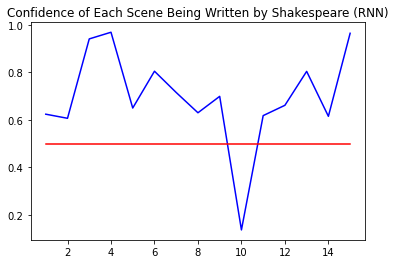

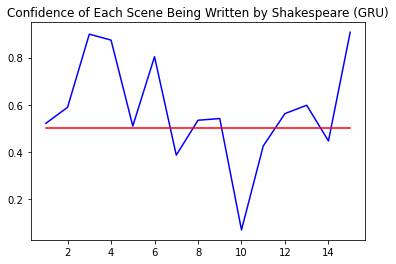

<Figure size 432x288 with 0 Axes>

In [142]:
predictionsrnn = [val1rnn, val2rnn, val3rnn, val4rnn, val5rnn, val6rnn, val7rnn, val8rnn, val9rnn, val10rnn, val11rnn, val12rnn, val13rnn, val14rnn, val15rnn]
predictionsgru = [val1gru, val2gru, val3gru, val4gru, val5gru, val6gru, val7gru, val8gru, val9gru, val10gru, val11gru, val12gru, val13gru, val14gru, val15gru]
scenes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
midline = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

plt.plot(scenes, predictionsrnn, 'b', label='Confidence')
plt.plot(scenes, midline, 'r', label='Confidence')

plt.title('Confidence of Each Scene Being Written by Shakespeare (RNN)')

plt.figure()

plt.plot(scenes, predictionsgru, 'b', label='Confidence')
plt.plot(scenes, midline, 'r', label='Confidence')

plt.title('Confidence of Each Scene Being Written by Shakespeare (GRU)')

plt.figure()